<a href="https://colab.research.google.com/github/alex-addanki/Experiments/blob/master/Hackathon_Spoken_Digit_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
os.listdir(r"/content/")

# Any results you write to the current directory are saved as output.

In [0]:
from keras.utils import to_categorical
from tqdm import tqdm

def wav2mfcc(file_path, augment = False, max_pad_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=8000, duration = 1.024)
    
    if augment == True:
        bins_per_octave = 12
        pitch_pm = 4
        pitch_change =  pitch_pm * 2*(np.random.uniform())   
        wave = librosa.effects.pitch_shift(wave, 
                                          8000, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
        
        speed_change = np.random.uniform(low=0.9,high=1.1)
        wave = librosa.effects.time_stretch(wave, speed_change)
        wave = wave[:8192]

    duration = wave.shape[0]/sr
    speed_change = 2.0* duration/1.024
    wave = librosa.effects.time_stretch(wave, speed_change)
    wave = wave[:4096]
    
    wave = librosa.util.normalize(wave)
    mfcc = librosa.feature.mfcc(wave, sr=sr, n_mfcc=40, hop_length=int(0.048*sr), n_fft=int(0.096*sr))
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    #print("shape=",mfcc.shape[1], wave.shape[0])
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    #mfcc = mfcc[2:24,:]
    return mfcc, duration, sr

def get_data(dir = '', augment= False):
    labels = []
    mfccs = []
    durations = []
    sampling_rates = []
    filenames = []

    for f in tqdm(os.listdir(dir)):
        if f.endswith('.wav'):
            mfcc, duration, sr = wav2mfcc(dir + "/" + f, augment)
            mfccs.append(mfcc)
            durations.append(duration)
            sampling_rates.append(sr)
            # List of labels
            label = f.split('_')[0]
            labels.append(label)
            filenames.append(dir + "/" + f)
    return filenames, np.asarray(mfccs), np.asarray(durations), np.asarray(sampling_rates), to_categorical(labels), labels

In [13]:
filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('/content/')

100%|██████████| 962/962 [02:06<00:00,  7.63it/s]


In [0]:
import matplotlib.pyplot as plt
import librosa.display

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    max = np.max(images)
    min = np.min(images)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        #ax.imshow(images[i].reshape(img_shape), cmap='binary')
        im = librosa.display.specshow(images[i], ax=ax, vmin=min, vmax=max)

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

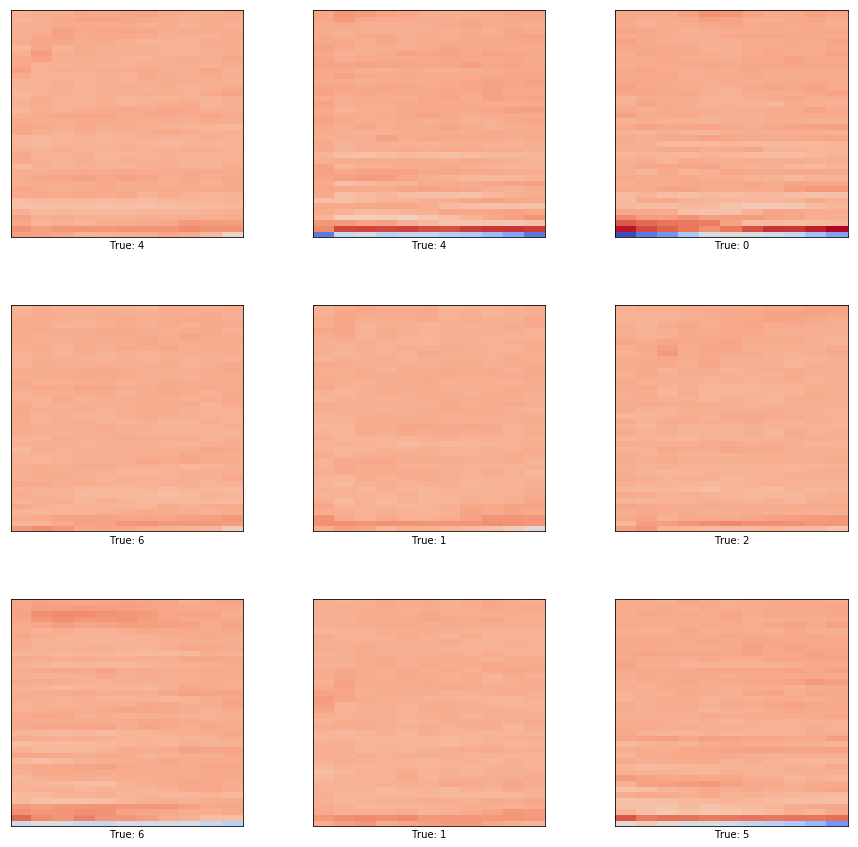

In [15]:
plot_images(mfccs[100:109], cls_true[100:109])

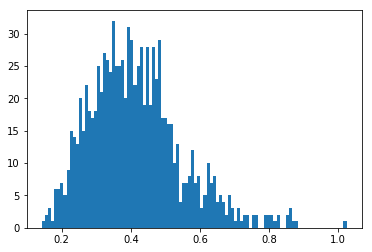

In [16]:
n, bins, patches = plt.hist(durations, bins=100)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

#from ann_visualizer.visualize import ann_viz

def get_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(120, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

    return model

In [0]:
from sklearn.model_selection import train_test_split

def get_all():
    filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('/content/', augment = False)
    
    filenames_a, mfccs_a, durations_a, sampling_rates_a, labels_a, cls_true_a = get_data('/content/', augment = True)

    mfccs = np.append(mfccs, mfccs_a, axis=0)
    labels = np.append(labels, labels_a, axis =0)
    
    dim_1 = mfccs.shape[1]
    dim_2 = mfccs.shape[2]
    channels = 1
    classes = 10
    
    print("sampling rate (max) = ", np.max(sampling_rates))
    print("sampling rate (min) = ", np.min(sampling_rates))
    print("duration (max) = ", np.max(durations))
    print("duration (avg) = ", np.average(durations))
    print("duration (min) = ", np.min(durations))
    print("mffc matrix = ", mfccs.shape)

    X = mfccs
    X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
    y = labels

    input_shape = (dim_1, dim_2, channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    model = get_cnn_model(input_shape, classes)

    return X_train, X_test, y_train, y_test, model

In [19]:
X_train, X_test, y_train, y_test, cnn_model = get_all()

print(cnn_model.summary())

cnn_model.fit(X_train, y_train, batch_size=64, epochs=15, verbose=1, validation_split=0.1)

100%|██████████| 962/962 [02:21<00:00,  6.78it/s]


sampling rate (max) =  8000
sampling rate (min) =  8000
duration (max) =  1.024
duration (avg) =  0.4134175420168067
duration (min) =  0.143625
mffc matrix =  (1904, 40, 11)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 37, 8, 32)         544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 8, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 6, 48)         13872     
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 6, 48)         192       
_____________________________________________

In [0]:
from sklearn.metrics import classification_report
predictions = cnn_model.predict_classes(X_test)
#print(classification_report(y_test, to_categorical(predictions)))

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test, axis=1), predictions, labels=[0,1,2,3,4,5,6,7,8,9])

array([[63,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 2, 46,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 2,  0, 49,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 24,  0,  0,  0,  0,  0,  0],
       [ 2,  1,  0,  0, 49,  0,  1,  0,  0,  0],
       [ 1,  3,  0,  0,  2, 50,  0,  0,  0,  0],
       [ 3,  0,  1,  0,  0,  1, 49,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0, 21,  0,  0],
       [ 0,  0,  1,  1,  0,  0,  1,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

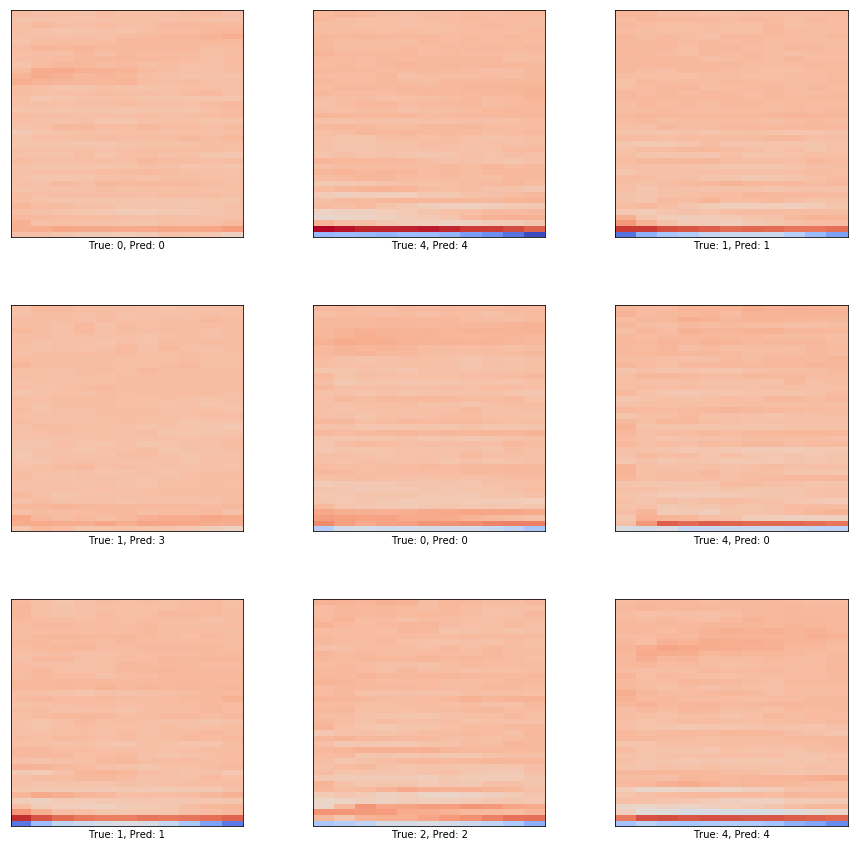

In [27]:
n = X_test[100:109]
n = n.reshape(n.shape[0], n.shape[1], n.shape[2])
plot_images(n, np.argmax(y_test[100:109], axis=1), predictions[100:109])